In [248]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize, LogNorm, PowerNorm
import cv2
import PIL

from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import resize
import matplotlib.pyplot as plt

In [249]:
!gdown https://drive.google.com/uc?id=1lJKLz3LsQmnAf9q5GGi6arEYBz-3CMhx -O 20240507.rar
!mkdir -p ./20240507_cut_npy
!unrar x 20240507.rar ./20240507_cut_npy
!rm 20240507.rar

'gdown' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.
'unrar' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [250]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

In [251]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(a))

In [252]:
def get_time_interval(files, start, end):
    """
    Retrieves and concatenates data from a specified time interval based on file names.

    Parameters:
    ----------
    files : list of str
        A list of file paths, where each file contains data for a specific time interval.
    start : str
        The starting time of the interval in the format "HHMMSS" (e.g., "090000" for 9:00:00).
    end : str
        The ending time of the interval in the format "HHMMSS" (e.g., "100000" for 10:00:00).

    Returns:
    -------
    tuple
        A tuple containing:
        - ndarray: A concatenated 2D array containing the data from all files in the specified time interval.
        - str: The file path corresponding to the first file in the interval.
    """
    data = []
    first_file = '20240507_cut_npy\\' + start + '.npy' #/
    last_file = '20240507_cut_npy\\' + end + '.npy' #/
    for file in files:
        if file >= first_file and file <= last_file:
            data.append(np.load(file))

    data = np.concatenate(data)
    return data, first_file

In [253]:
def get_proper_df(data, first_file, dx= 5.106500953873407, dt= 0.0016):
    """
    Converts raw data into a properly indexed and normalized DataFrame.

    Parameters:
    ----------
    data : ndarray
        The raw data to be converted into a DataFrame. This is a 2D array where each row represents a time step, 
        and each column corresponds to a spatial position.
    first_file : str
        The name of the first file used for generating the time index. It should be in the format "YYYYMMDD_HHMMSS.npy".
    dx : float, optional
        The spatial step size, i.e., the distance between consecutive spatial points (default is 5.1065).
    dt : float, optional
        The time step size, i.e., the time interval between consecutive time steps (default is 0.0016 seconds).

    Returns:
    -------
    pd.DataFrame
        A DataFrame with time as the index, spatial positions as columns, and the normalized, absolute values 
        of the original data. The data is also centered around its mean before taking the absolute value.
    """
    time_start = datetime.datetime.strptime('2024-05-07 ' + first_file.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S") #/
    index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')
    columns = np.arange(len(data[0])) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    df -= df.mean()
    df = np.abs(df)

    return df

In [254]:
path_out = '20240507_cut_npy/'
files = glob.glob(path_out+"*")
files.sort()

In [255]:
data, first_file = get_time_interval(files, '092352', '092542')
df = get_proper_df(data, first_file)

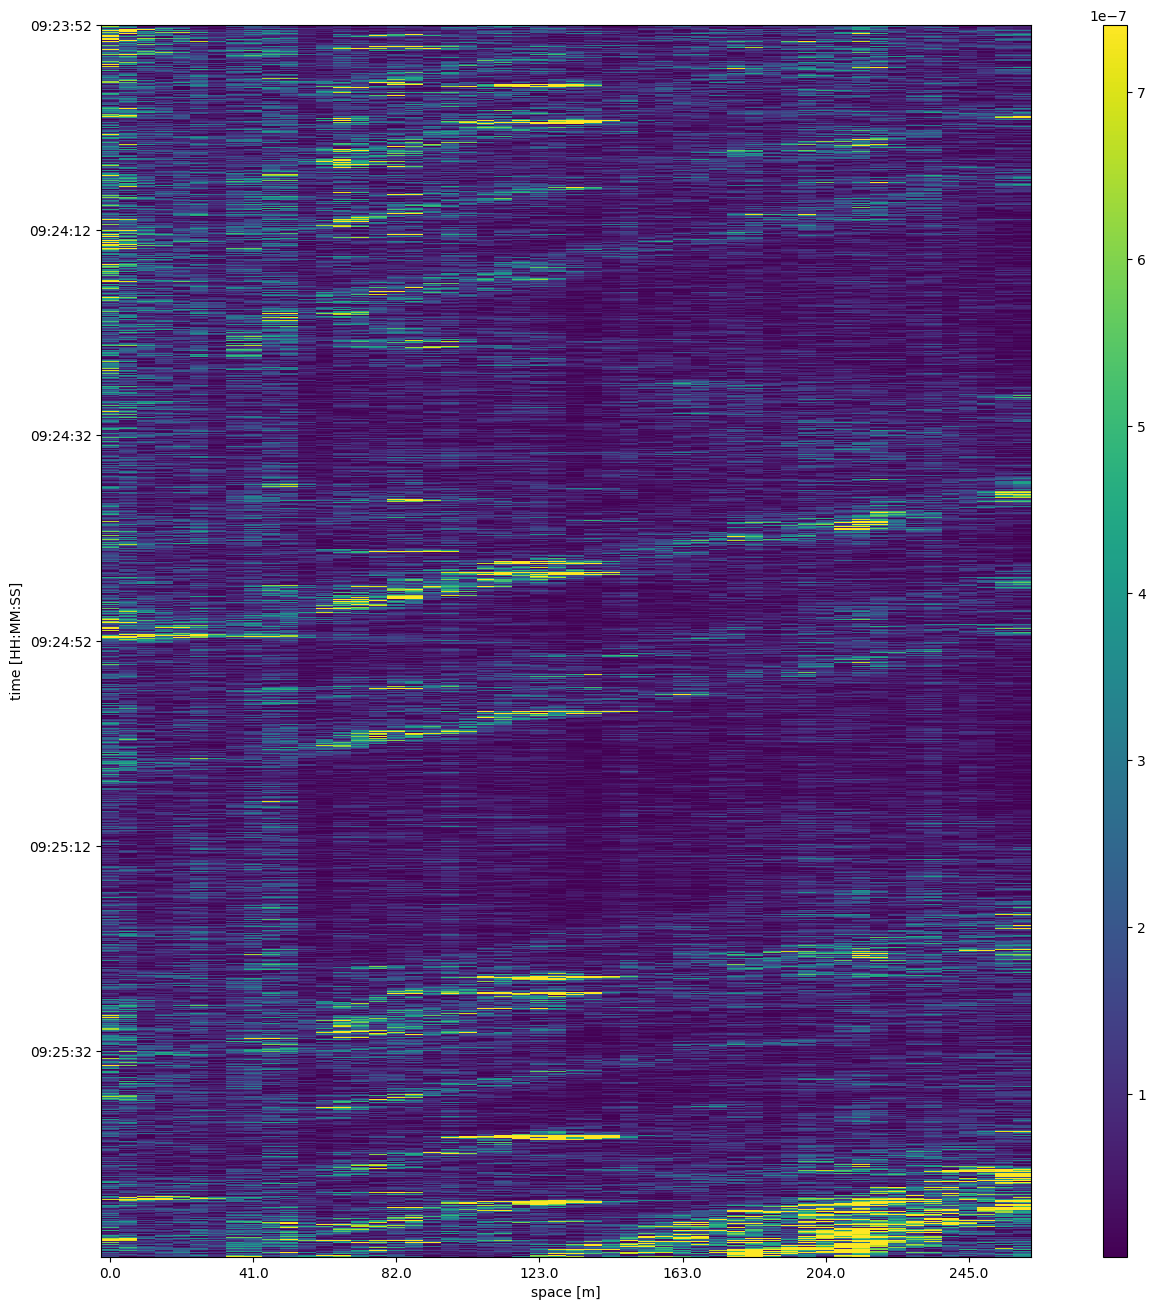

In [256]:
fig = plt.figure(figsize=(12,16))
ax = plt.axes()

low, high = np.percentile(df, [3, 99]) 
norm = Normalize(vmin=low, vmax=high, clip=True)

im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
plt.ylabel('time [HH:MM:SS]')
plt.xlabel('space [m]')

cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
x_positions, x_labels = set_axis(df.columns)
ax.set_xticks(x_positions, np.round(x_labels))
y_positions, y_labels = set_axis(df.index.time)
ax.set_yticks(y_positions, y_labels)
plt.show()


# **Data analisys** #

In [257]:
# basic info about dataframe
np.info(df.values)
print("Max:", np.max(df))
print("Min:", np.min(df))
print("Mean:", np.mean(df))
print(np.percentile(df, [0, 5, 25, 50, 75, 95, 100]))

class:  ndarray
shape:  (75000, 52)
strides:  (208, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x1b128f1e040
byteorder:  little
byteswap:  False
type: float32
Max: 2.972713e-05
Min: 8.790718e-12
Mean: 1.1305762e-07
[8.79071815e-12 4.82473217e-09 2.84826793e-08 6.69117384e-08
 1.32913272e-07 3.44083676e-07 2.97271308e-05]


In [258]:
def plotting_function(data, idx, cols, norm=None):
    """
    Visualizes a 2D dataset as a heatmap with labeled axes and a color bar.

    Parameters:
    ----------
    data : ndarray
        The 2D array containing the data to be plotted.
    idx : iterable
        The row index for the data, corresponding to time.
    cols : iterable
        The column index for the data, corresponding to space.
    norm : matplotlib.colors.Normalize, optional
        A normalization instance to scale the colormap. If None, no normalization is applied.

    Returns:
    -------
    None
        The function displays the heatmap and does not return any value.
    """
    df = pd.DataFrame(data, index = idx, columns=cols)

    fig = plt.figure(figsize=(12,16))
    ax = plt.axes()
    
    if norm is not None:
        im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
    else:
        im = ax.imshow(df,interpolation='none',aspect='auto')

    plt.ylabel('time [HH:MM:SS]')
    plt.xlabel('space [m]')

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(cols)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    plt.show()

def display_gray(data, idx, cols, norm=None):
    """
    Visualizes a 2D dataset as a heatmap in a grayscale with labeled axes and a color bar.

    Parameters:
    ----------
    data : ndarray
        The 2D array containing the data to be plotted.
    idx : iterable
        The row index for the data, corresponding to time.
    cols : iterable
        The column index for the data, corresponding to space.
    norm : matplotlib.colors.Normalize, optional
        A normalization instance to scale the colormap. If None, no normalization is applied.

    Returns:
    -------
    None
        The function displays the heatmap in a grayscale and does not return any value.
    """
    df = pd.DataFrame(data, index = idx, columns=cols)

    fig = plt.figure(figsize=(12,16))
    ax = plt.axes()
    
    if norm is not None:
        im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm, cmap='gray')
    else:
        im = ax.imshow(df,interpolation='none',aspect='auto', cmap='gray')

    plt.ylabel('time [HH:MM:SS]')
    plt.xlabel('space [m]')

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(cols)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    plt.show()

## **Step 0** ##

### **a) Plotting raw data** ###

In [259]:
# plt.imshow(data, aspect='auto', origin='lower', cmap='plasma')
# plt.colorbar(label='Amplitude')
# plt.title('DAS Data: Heatmap')
# plt.xlabel('Time')
# plt.ylabel('Distance')
# plt.show()

### **b) Min-Max normalization** ###

In [260]:
# low, high = np.percentile(df, [0, 100]) 
# norm = Normalize(vmin=low, vmax=high, clip=True)

# plotting_function(abs(data), index, columns, norm)

### **b) Min-Max Normalization upgraded** ###

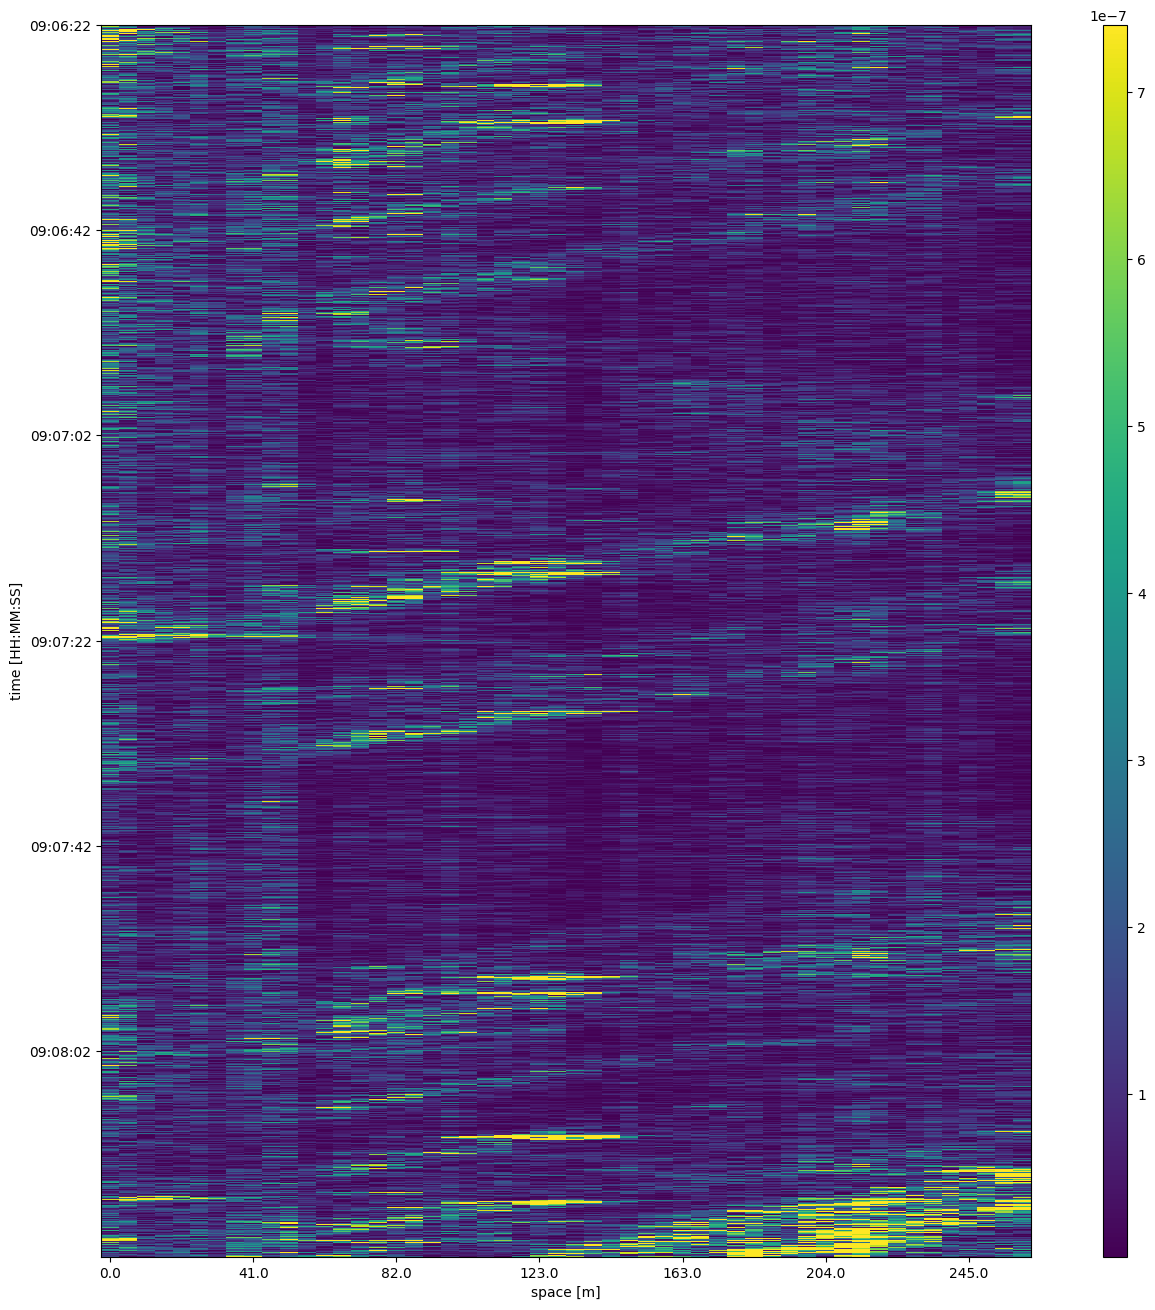

In [261]:
low, high = np.percentile(df, [3, 99]) 
norm_mm = Normalize(vmin=low, vmax=high, clip=True)

plotting_function(abs(data), index, columns, norm_mm)

### **c) Log scaling** ###

In [262]:
# low, high = np.percentile(df, [2, 98]) 
# norm_log = LogNorm(vmin=low, vmax=high, clip=True)

# plotting_function(abs(data), index, columns, norm_log)

### **d) Power Norm Scaling** ###

In [263]:
# low, high = np.percentile(df, [2, 98]) 
# norm_power = PowerNorm(vmin=low, vmax=high, clip=True, gamma = 2) #The higher gamma, the less noise we have in data but also less data

# plotting_function(abs(data), index, columns, norm_power)

### **d) Standardized data** ###

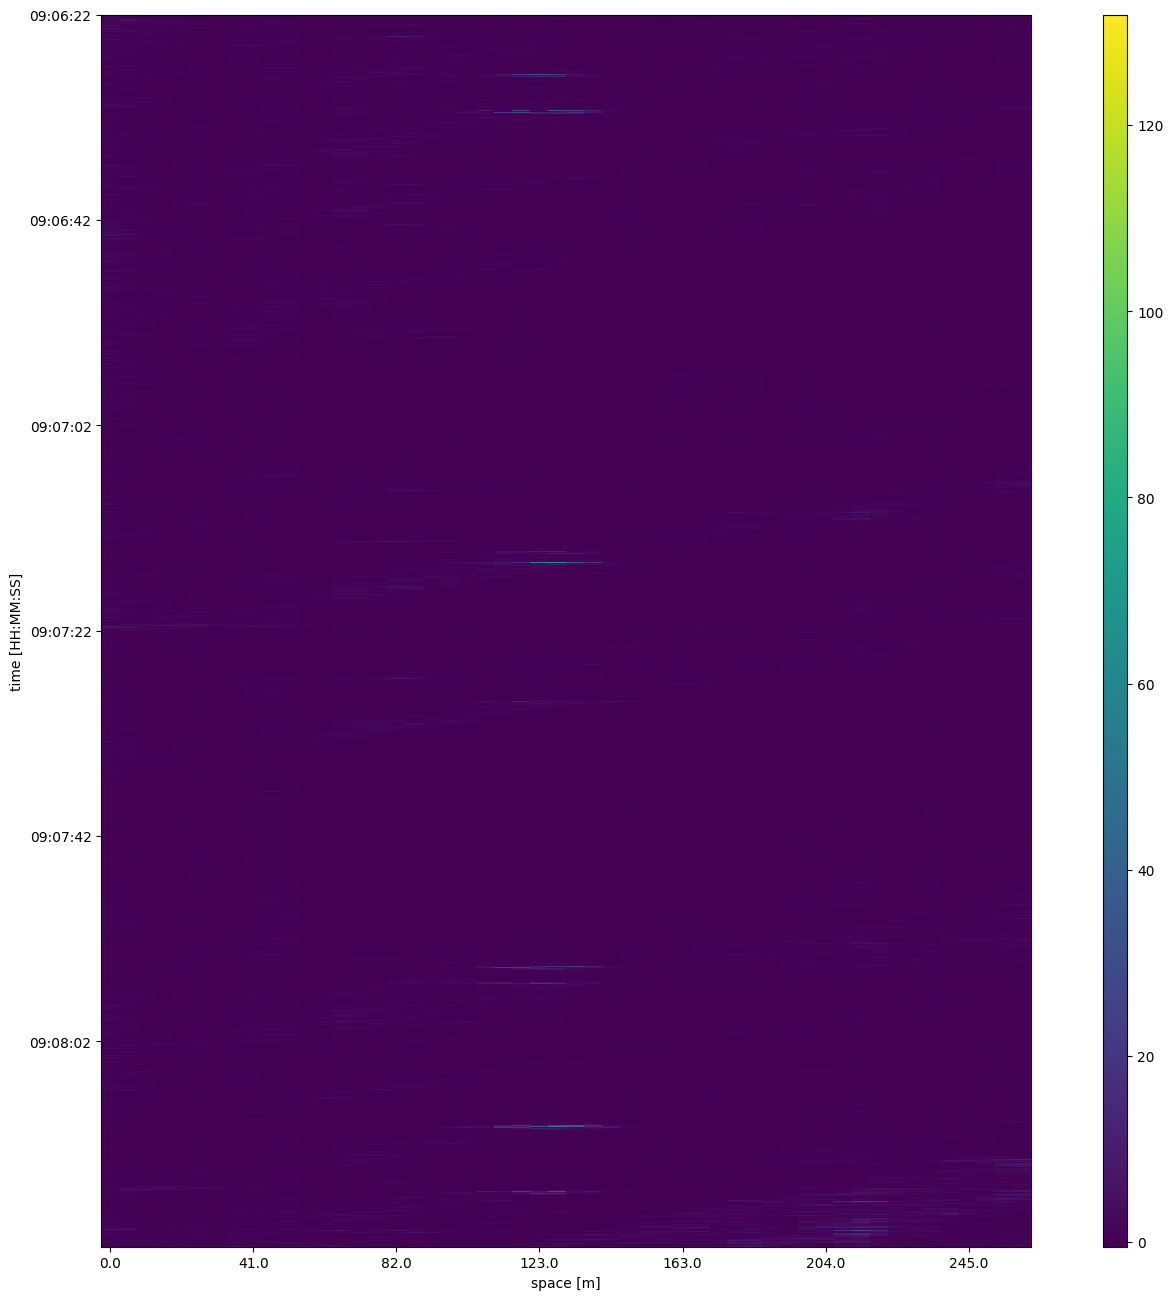

In [264]:
standardized_data = (abs(data) - np.mean(abs(data))) / np.std(abs(data))

plotting_function(standardized_data, index, columns)

### **e) Grayscale image** ###

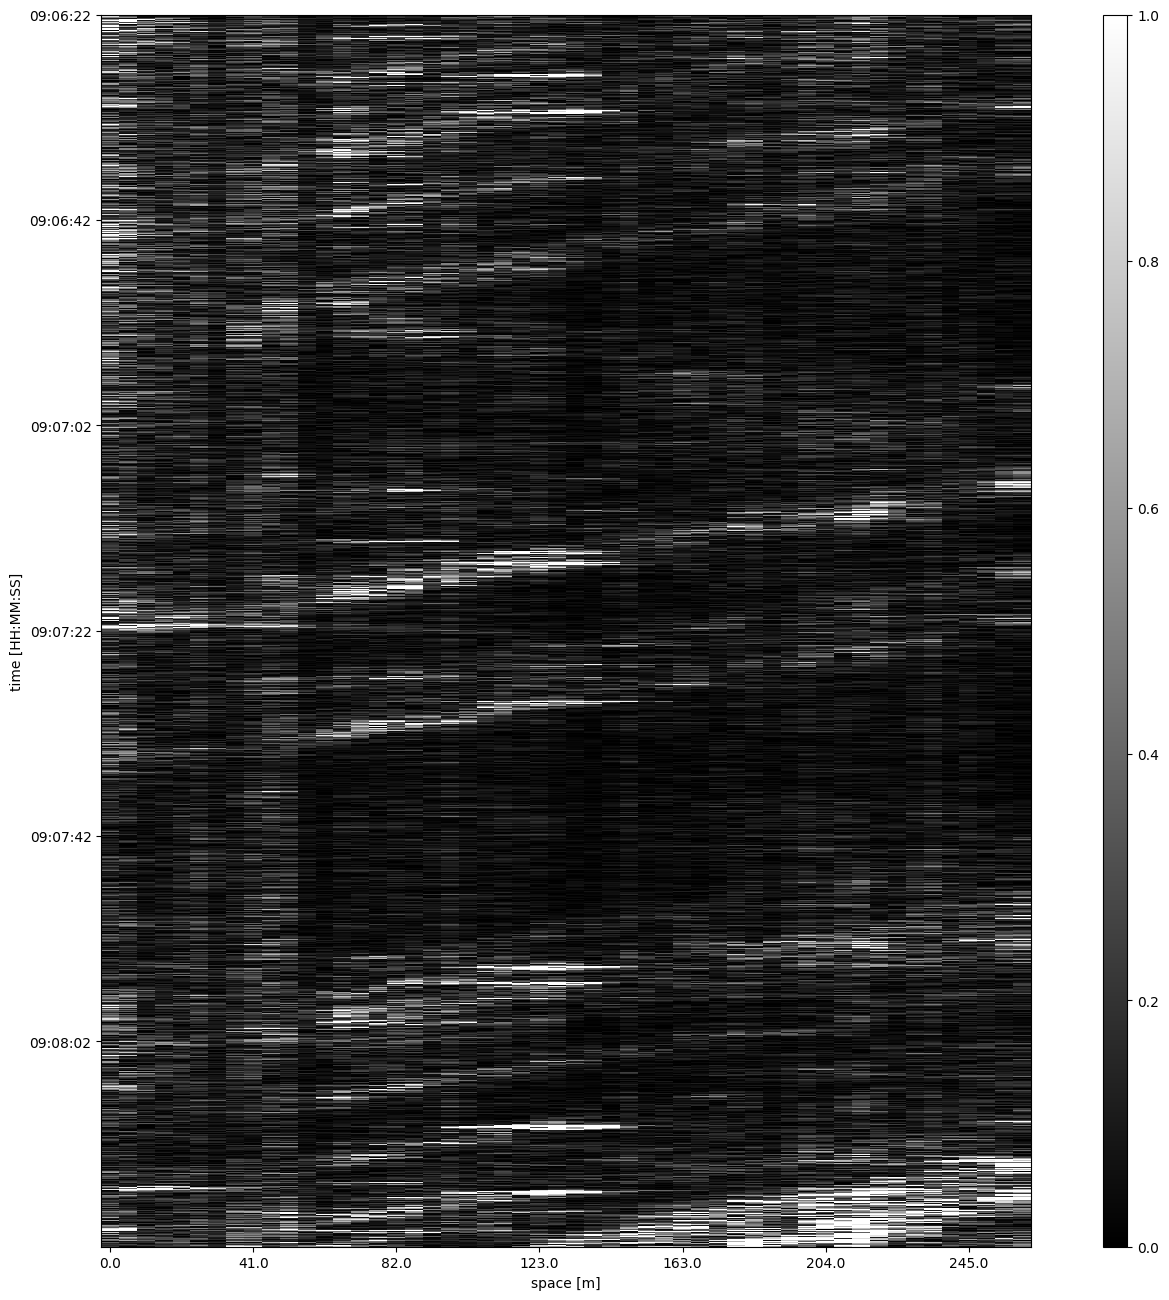

In [265]:
norm_mm_data = norm_mm(abs(data))
# norm_log_data = norm_log(abs(data))
# norm_power_data = norm_power(abs(data))
standardized_data = (abs(data) - np.mean(abs(data))) / np.std(abs(data))

display_gray(norm_mm_data, index, columns)

In [266]:
# display_gray(norm_log_data, index, columns)

In [267]:
# display_gray(norm_power_data, index, columns)

### **f) Binarized Image** ###

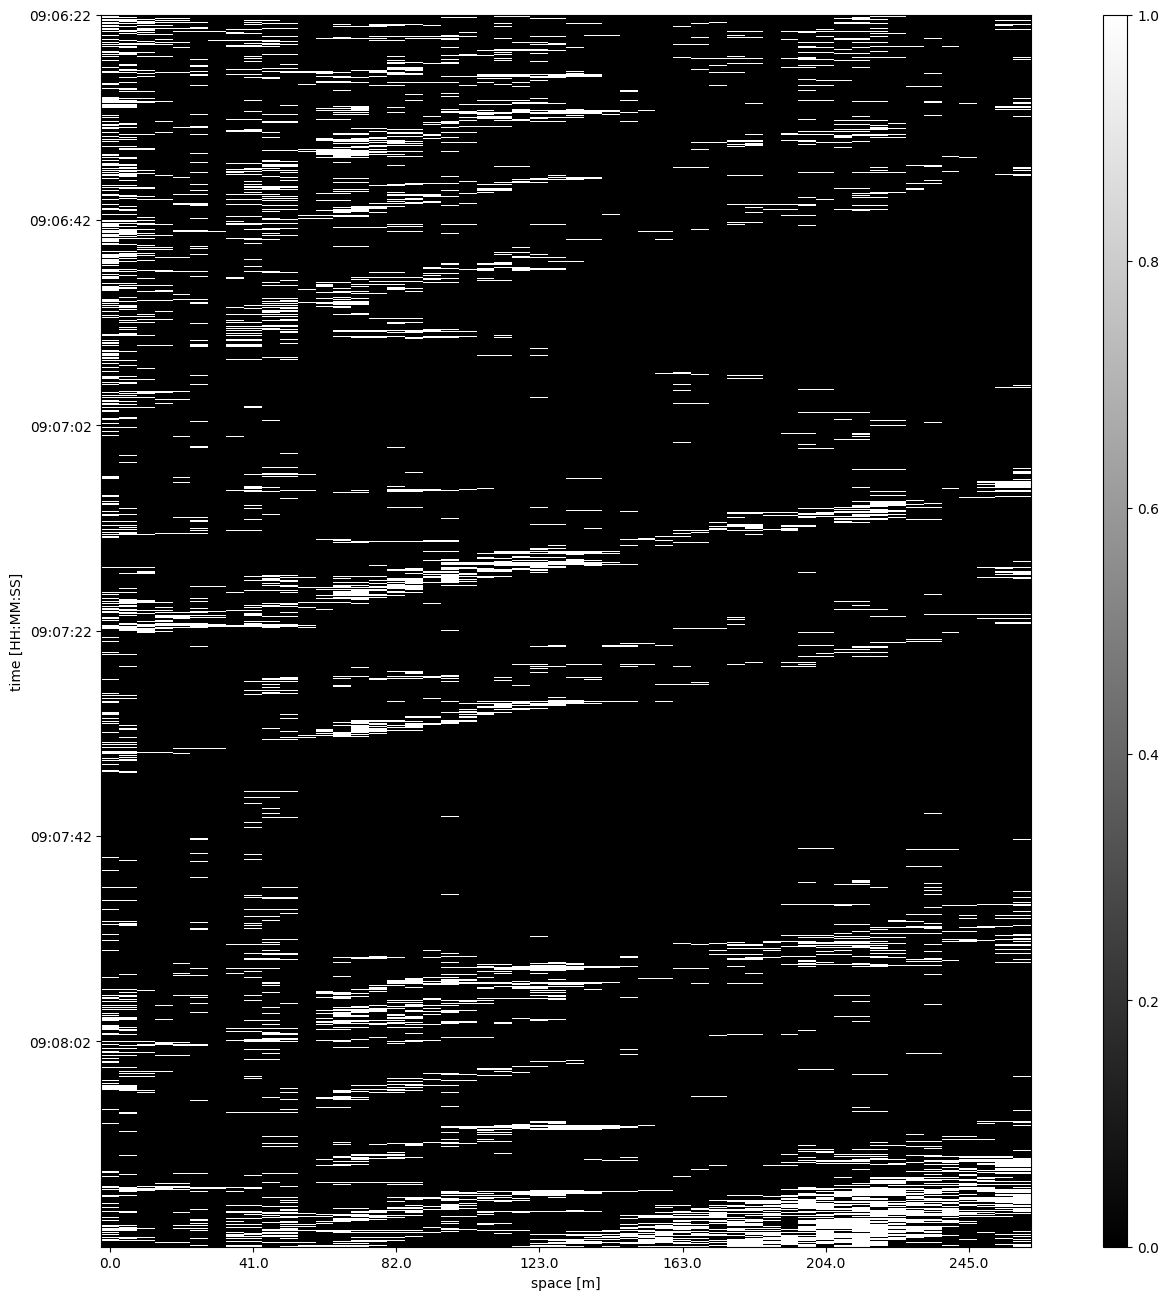

In [268]:
threshold = np.percentile(standardized_data, [86])
binarized_img = norm_mm_data > threshold
display_gray(binarized_img, index, columns) # No matter which data we take, result is always the samex

### **g) Morphological operations** ###

#### **1. Proper Closing** ####

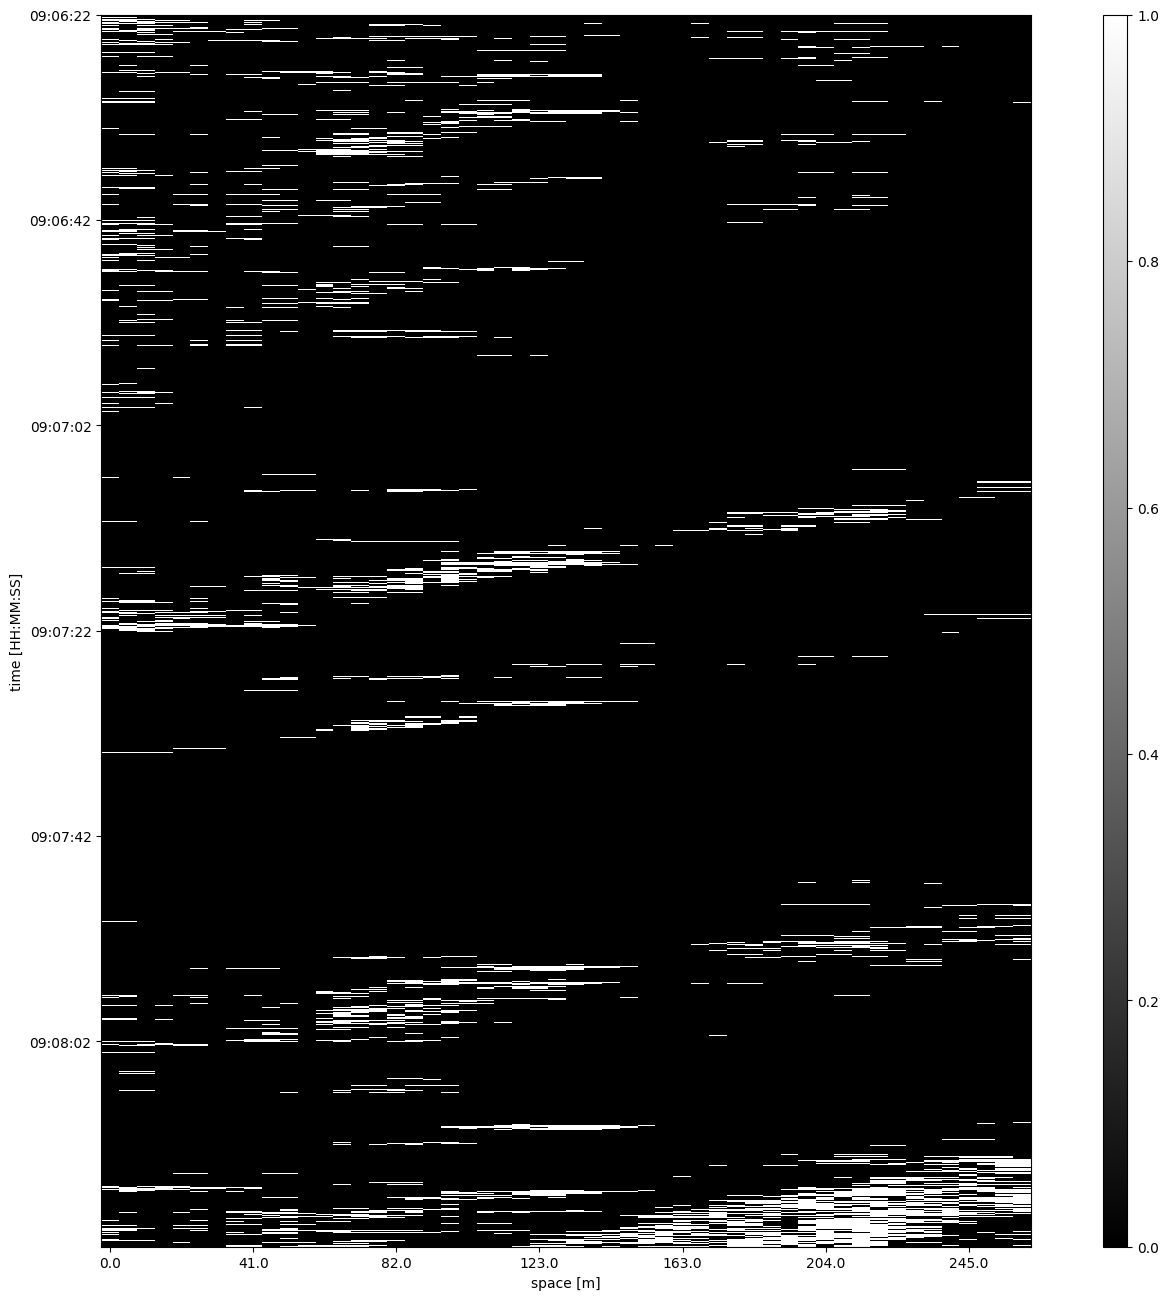

In [269]:
struct = np.ones([5, 5], np.uint8)

operation_1a = cv2.morphologyEx(binarized_img.astype(np.uint8) * 255, cv2.MORPH_CLOSE, struct)
operation_1b = cv2.morphologyEx(operation_1a, cv2.MORPH_OPEN, struct)
operation_1c = cv2.morphologyEx(operation_1b, cv2.MORPH_CLOSE, struct)
operation_1 = np.minimum(binarized_img, operation_1c)

display_gray(operation_1, index, columns)

#### **2. Proper Opening** ####

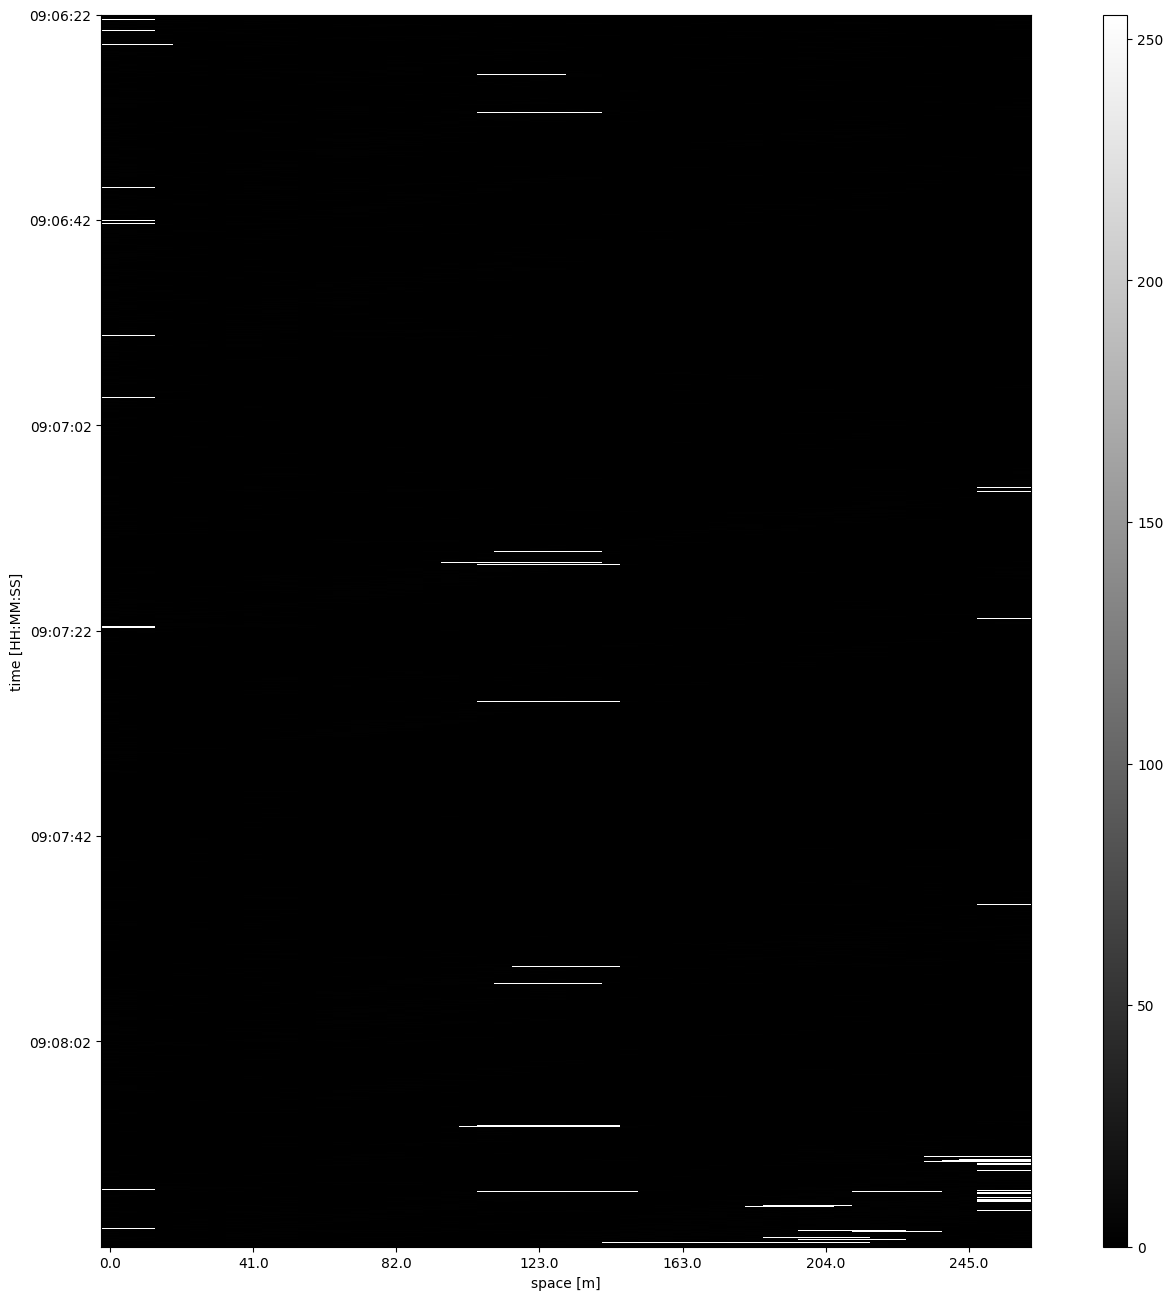

In [270]:
operation_2a = cv2.morphologyEx(binarized_img.astype(np.uint8) * 255, cv2.MORPH_OPEN, struct)
operation_2b = cv2.morphologyEx(operation_2a, cv2.MORPH_CLOSE, struct)
operation_2c = cv2.morphologyEx(operation_2b, cv2.MORPH_OPEN, struct)
operation_2 = np.maximum(binarized_img, operation_2c)

display_gray(operation_2, index, columns)

#### **Automedian Filter** ####

In [271]:
def automedian_filter(img, struct):
    img_c = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_co = cv2.morphologyEx(img_c, cv2.MORPH_OPEN, struct)
    img_coc = cv2.morphologyEx(img_co, cv2.MORPH_CLOSE, struct)

    img_o = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_oc = cv2.morphologyEx(img_o, cv2.MORPH_CLOSE, struct)
    img_oco = cv2.morphologyEx(img_oc, cv2.MORPH_OPEN, struct)

    Q_f = np.minimum(img_coc, img)
    A_f = np.maximum(Q_f, img_oco)

    return A_f

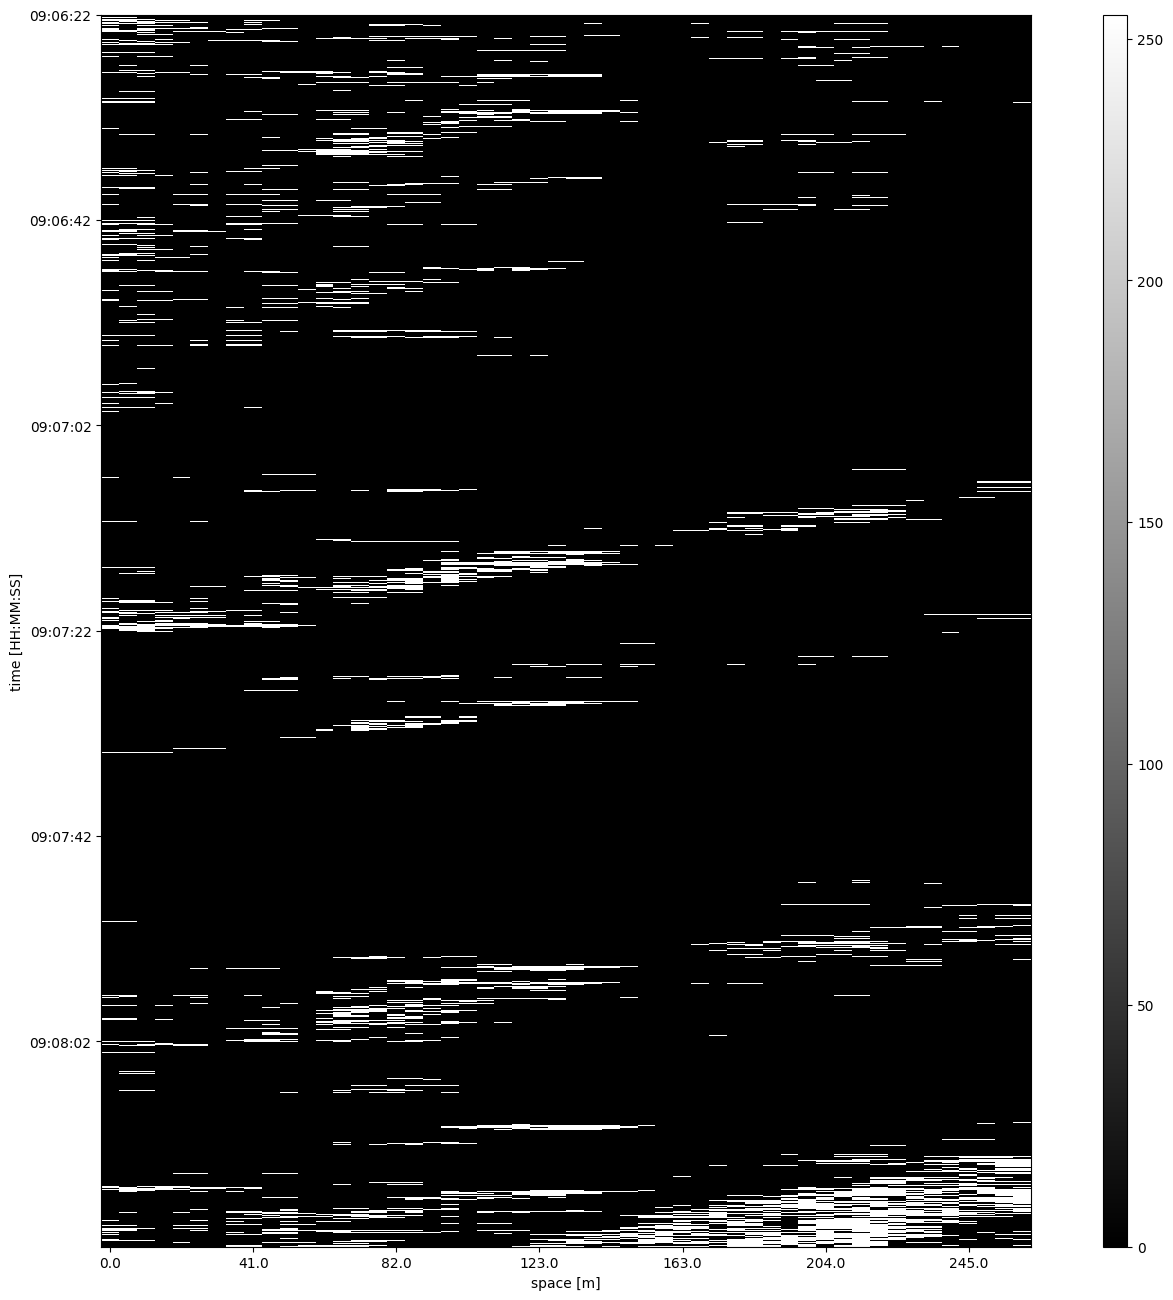

In [272]:
operation_3 = automedian_filter(binarized_img.astype(np.uint8) * 255, struct) # AUTOMEDIAN FILTER
display_gray(operation_3, index, columns)

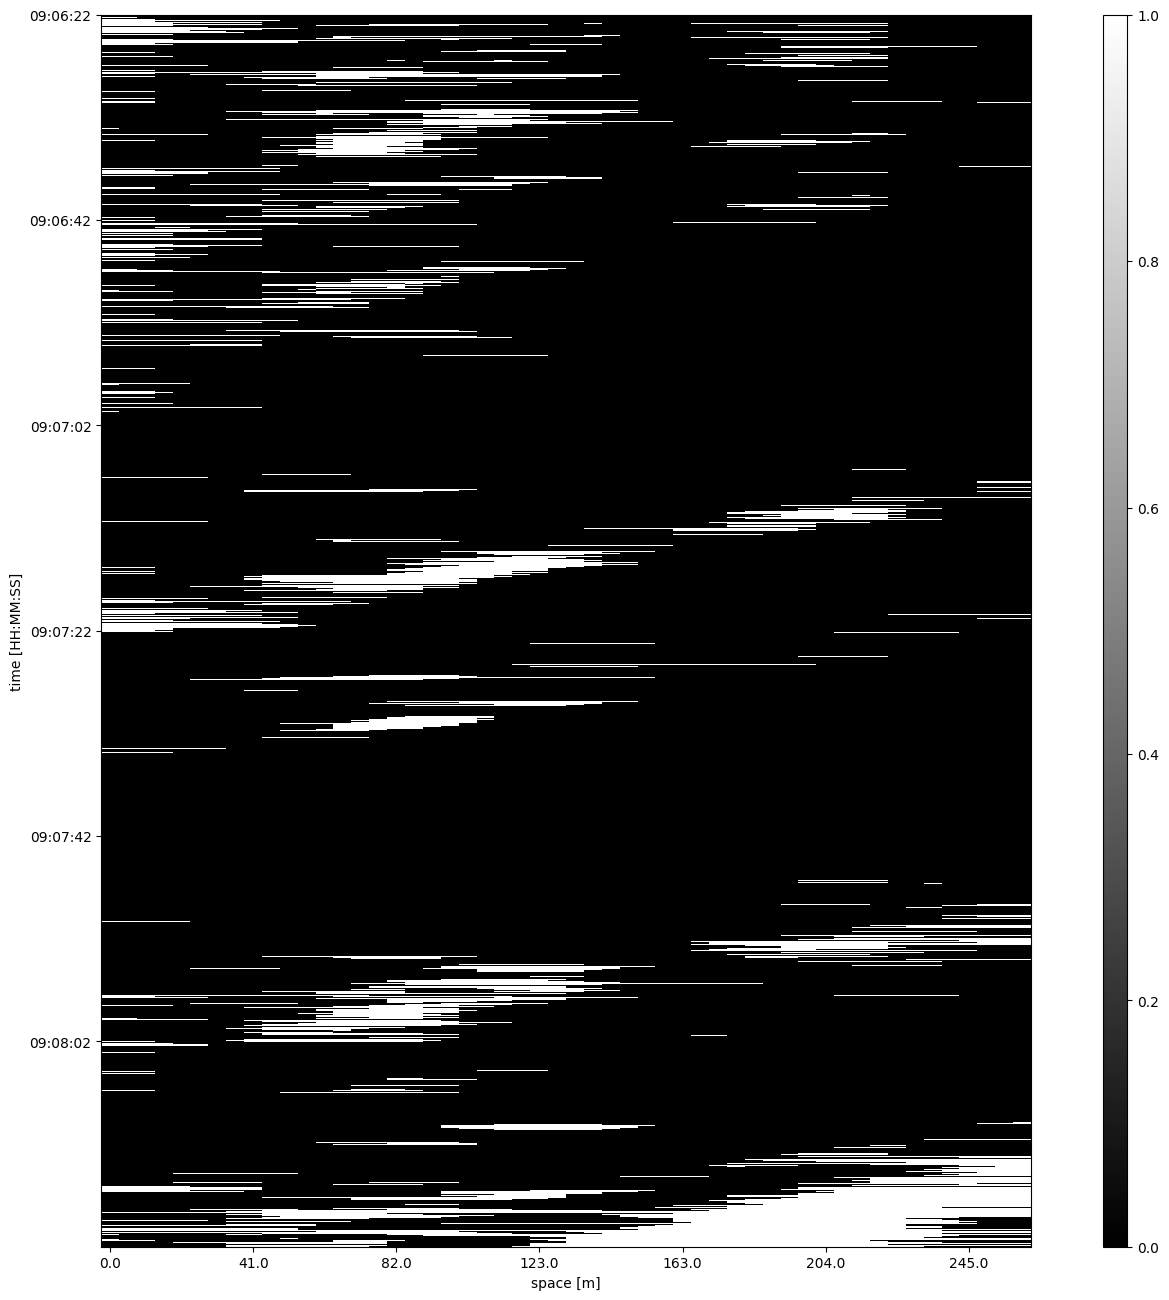

In [273]:
operation_4 = cv2.morphologyEx(operation_3.astype(np.uint8) * 255, cv2.MORPH_CLOSE, struct) # AUTOMEDIAN FILTER, CLOSING
display_gray(operation_4, index, columns)

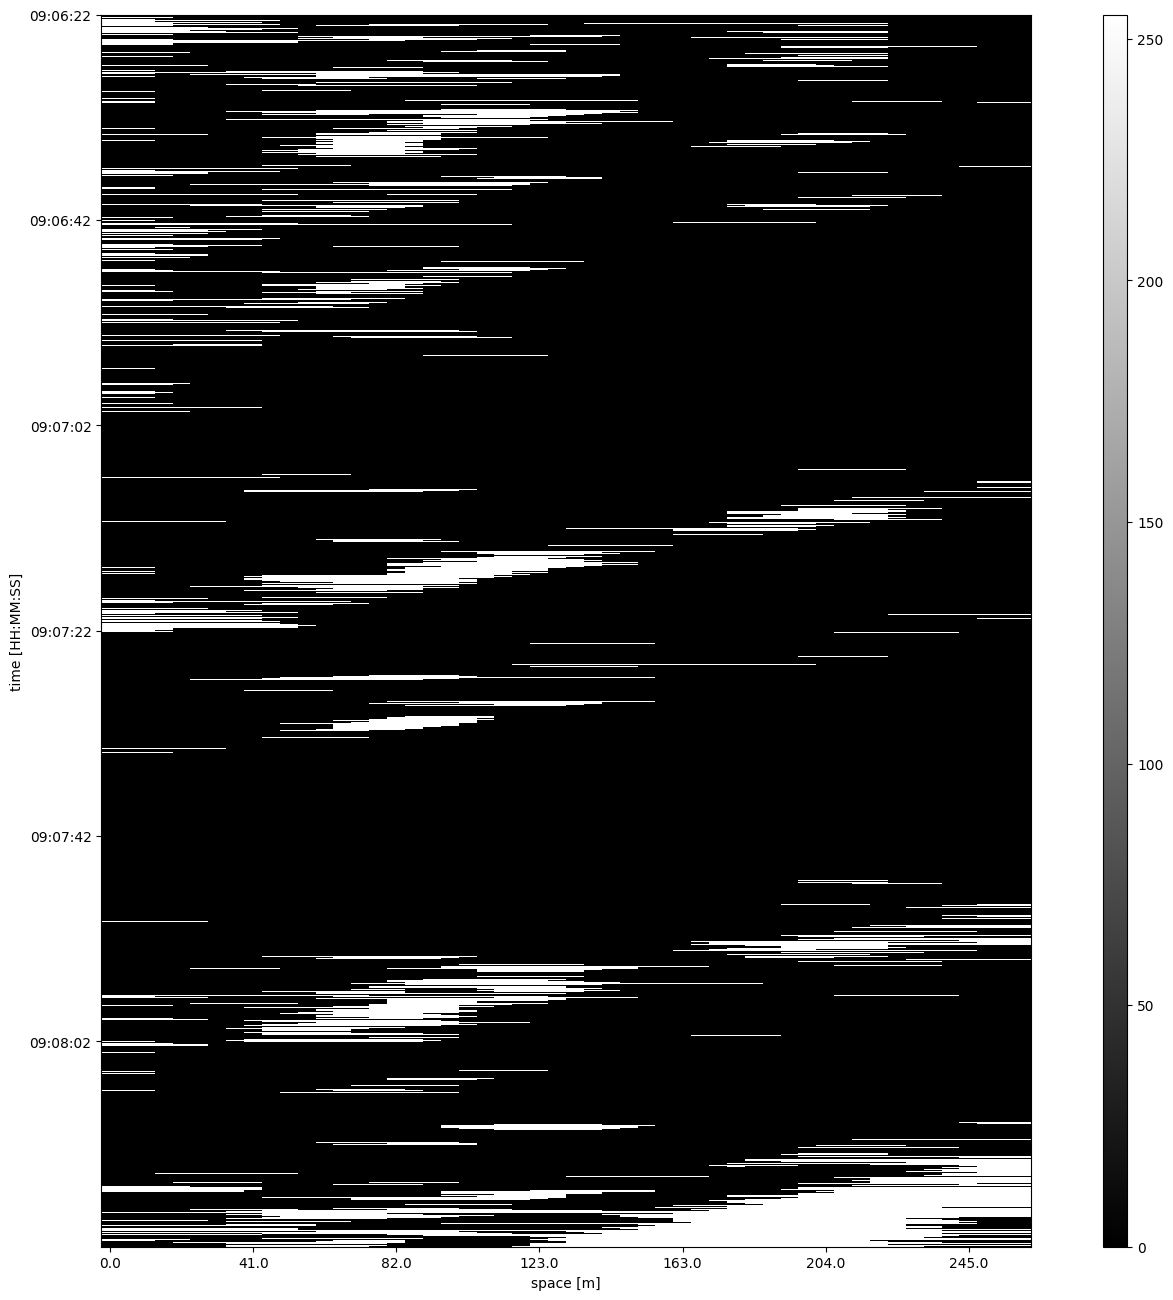

In [274]:
operation_5 = cv2.morphologyEx(binarized_img.astype(np.uint8) * 255, cv2.MORPH_CLOSE, struct) # CLOSING
operation_5 = automedian_filter(operation_5.astype(np.uint8) * 255, struct) # AUTOMEDIAN
operation_5 = automedian_filter(operation_5.astype(np.uint8) * 255, struct) # AUTOMEDIAN 2
display_gray(operation_5, index, columns)

Original shape: (75000, 52)
Resized shape: (750, 572)


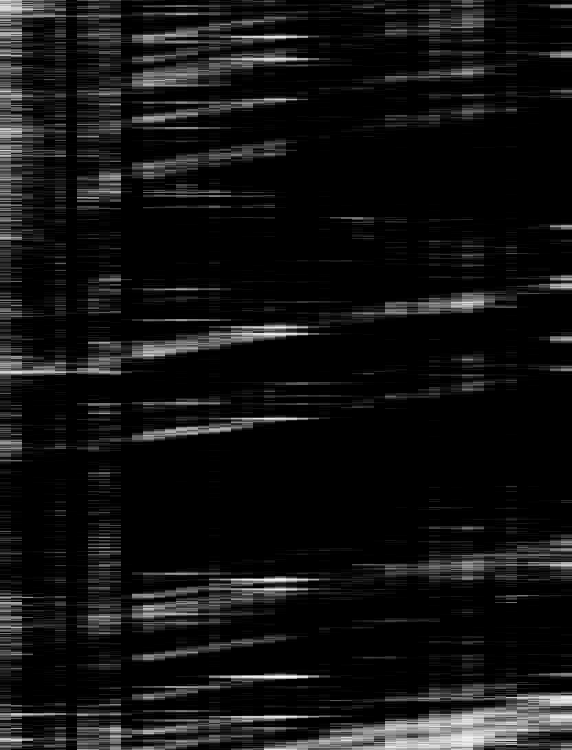

In [275]:
def downsample_vertical(image, factor):
    """
    Reduces the vertical resolution of an image by averaging groups of rows.

    Parameters:
    ----------
    image : ndarray
        The input 2D array representing the image.
    factor : int, optional
        The factor by which to downsample the image vertically.

    Returns:
    -------
    ndarray
        The vertically downsampled image, with the number of rows reduced by the specified factor.
    """
    return image.reshape(image.shape[0] // factor, factor, image.shape[1]).mean(axis=1)


def expand_horizontal(image, factor):
    """
    Expands the horizontal resolution of an image by repeating each pixel value.

    Parameters:
    ----------
    image : ndarray
        The input 2D array representing the image.
    factor : int, optional
        The number of times each pixel value is repeated horizontally.

    Returns:
    -------
    ndarray
        The horizontally expanded image, with the number of columns increased by the specified factor.
    """
    return np.repeat(image, factor, axis=1)


def scale_to_255(image):
    """
    Normalizes an image to the range 0-255.

    Parameters:
    ----------
    image : ndarray
        The input 2D array representing the image.

    Returns:
    -------
    ndarray
        The normalized image scaled to the range 0-255 and converted to uint8.
    """
    scaled_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return (scaled_image * 255).astype(np.uint8)


downsampled_img = downsample_vertical(binarized_img, factor=100)
resized_img = expand_horizontal(downsampled_img, factor=11)

print(f"Original shape: {norm_mm_data.shape}")
print(f"Resized shape: {resized_img.shape}")

scaled_img = scale_to_255(resized_img)

imshow(scaled_img)


In [276]:
# from sklearn.cluster import DBSCAN

# gray = scaled_image.astype(np.uint8)
# print("Grayscaled:")
# # imshow(gray)

# thr = np.percentile(gray, [90])

# binarized = (gray > thr).astype(np.uint8) * 255
# print("Binarized")
# # imshow(binarized)

# gray_auto = automedian_filter(binarized, np.ones((7, 7)))
# print("Grayscaled, automedian:")
# # imshow(gray_auto)

# gray_bl = cv2.GaussianBlur(gray_auto, (21, 21), 1)
# print("Grayscaled, automedian, blurred")
# # imshow(gray_bl)

# img_after_pre = gray_bl.copy()
# # imshow(img_after_pre)

# tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 361, endpoint=False)
# h, theta, d = hough_line(img_after_pre, theta=tested_angles)

# accumulator, angles, distances = hough_line_peaks(h, theta, d)

# # Combine distances and angles for clustering
# lines = np.column_stack((distances, angles))

# # Apply DBSCAN clustering
# dbscan = DBSCAN(eps = 36, min_samples=1).fit(lines)  # Adjust eps for clustering sensitivity
# unique_labels = set(dbscan.labels_)

# # Filter lines: Keep the most prominent line (highest accumulator) from each cluster
# filtered_lines = []
# for label in unique_labels:
#     cluster_indices = np.where(dbscan.labels_ == label)[0]
#     if cluster_indices.size > 0:
#         # Select the line with the highest accumulator value in the cluster
#         max_acc_idx = cluster_indices[np.argmax(accumulator[cluster_indices])]
#         filtered_lines.append((distances[max_acc_idx], angles[max_acc_idx]))

# # Visualization: Detected lines overlaid on the original image
# fig = plt.figure(figsize=(12, 16))
# ax = plt.axes()
# ax.imshow(img_after_pre)
# ax.set_ylim((img_after_pre.shape[0], 0))
# ax.set_xlim((0, img_after_pre.shape[1]))

# # Overlay filtered lines
# for dist, angle in filtered_lines:
#     # Example speed calculation (optional, adjust as needed)
#     speed = 1 / (abs(np.tan(angle + np.pi / 2) * (1100 * dt) / dx)) * 3.6
#     if 30 < speed < 150:  # Filter lines based on speed
#         x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
#         ax.axline(
#             (x0, y0),
#             slope=np.tan(angle + np.pi / 2),
#             color='red',
#             linewidth=2,
#             linestyle='--',
#             label=f"Slope: {np.tan(angle + np.pi / 2):.3f}, Speed: {speed:.1f} km/h",
#         )

# # Add legend for line parameters
# ax.legend(loc='upper right', fontsize='small')
# plt.tight_layout()
# plt.show()

In [277]:
def detect_lines(img, accumulator_threshold):
    """
    Detects prominent lines in an image using the Hough Transform.

    Parameters:
    ----------
    img : ndarray
        The input 2D array representing the image.
    accumulator_threshold : int or float
        The minimum accumulator value required to consider a line as valid.
        Higher values correspond to stronger detected lines.
        
    Returns:
    -------
    list of tuples
        A list of detected lines, where each line is represented as a tuple:
        (distance, angle, slope, speed).
        - `distance`: Distance from the origin to the line.
        - `angle`: Angle of the line in radians.
        - `slope`: Slope of the line.
        - `speed`: Vehicle speed calculated based on the line's slope.
    """
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img, theta=tested_angles)

    lines = []
    for accumulator, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        slope = np.tan(angle + np.pi / 2)
        denominator = slope * 1100 * dt / dx
        speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
        if 40 < speed < 130 and accumulator > accumulator_threshold:
            lines.append((dist, angle, slope, speed))
    
    return lines


def detect_lines_close_boundaries(img, pad_size, accumulator_threshold):
    """
    Detects prominent lines near the top and bottom boundaries of an image using padding and the Hough Transform.

    Parameters:
    ----------
    img : ndarray
        The input 2D array representing the image.
    pad_size : float
        Fraction of the image height to use as padding size.
    accumulator_threshold : int or float
        The minimum accumulator value required to consider a line as valid.
        Higher values correspond to stronger detected lines.

    Returns:
    -------
    list of tuples
        A list of detected lines close to the image boundaries, where each line is represented as a tuple:
        (distance, angle, slope, speed).
    """
    pad_h = int(pad_size * img.shape[0])
    img_pad = np.pad(img, ((pad_h, pad_h), (0, 0)), "edge")
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img_pad, theta=tested_angles)

    pad_lines = []
    for accumulator, angle, dist in zip(*hough_line_peaks(h, theta, d)): 
        slope = np.tan(angle + np.pi / 2)
        denominator = slope * 1100 * dt / dx
        speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
        if 40 < speed < 120 and accumulator > accumulator_threshold and (750 < np.abs(dist-pad_h) or np.abs(dist-pad_h) < 100):
            pad_lines.append((dist-pad_h, angle, slope, speed))
    
    return pad_lines

In [278]:
def filter_lines(lines, distance_threshold):
    """
    Filters detected lines based on distance, speed, and slope criteria to identify true prominent lines.
    Specificaly it confirms line if it is: first or further than distance_threshold from previous line
    or has lower speed or is in opposite direction.

    Parameters:
    ----------
    lines : list of tuples
        A list of detected lines descendingly sorted by distance, where each line is represented as a tuple:
        (distance, angle, slope, speed).

    Returns:
    -------
    list of tuples
        A filtered list of lines satisfying the criteria, where each line is represented as a tuple:
        (distance, angle, slope, speed).
    """
    true_lines = []
    previous_dist = None
    previous_speed = None
    previous_slope = None

    for dist, angle, slope, speed in lines:
        if previous_dist is None or previous_dist - dist > distance_threshold or speed < previous_speed or slope * previous_slope < 0:
            true_lines.append((dist, angle, slope, speed))
            
            previous_dist = dist
            previous_speed = speed
            previous_slope = slope
    
    return true_lines

In [279]:
def display_lines_on_scaled_img(img, lines):
    """
    Displays detected lines overlaid on the scaled image.

    Parameters:
    ----------
    img : ndarray
        The input 2D array representing the image.
    lines : list of tuples
        A list of detected lines, where each line is represented as a tuple:
        (distance, angle, slope, speed).

    Returns:
    -------
    None
        Displays the plot with lines overlaid on the input image.
    """
    fig, ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img)
    ax.set_ylim((img.shape[0], 0))
    ax.set_xlim((0, img.shape[1]))

    for dist, angle, slope, _ in lines:
        x0, y0 = (dist) * np.array([np.cos(angle), np.sin(angle)])
        ax.axline(
                (x0, y0),
                slope=slope,
                color='red',
                linewidth=2,
                linestyle='--',
            )
        
    plt.tight_layout()

C:\Users\user\AppData\Local\Temp\ipykernel_7544\2407331224.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
C:\Users\user\AppData\Local\Temp\ipykernel_7544\2407331224.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)


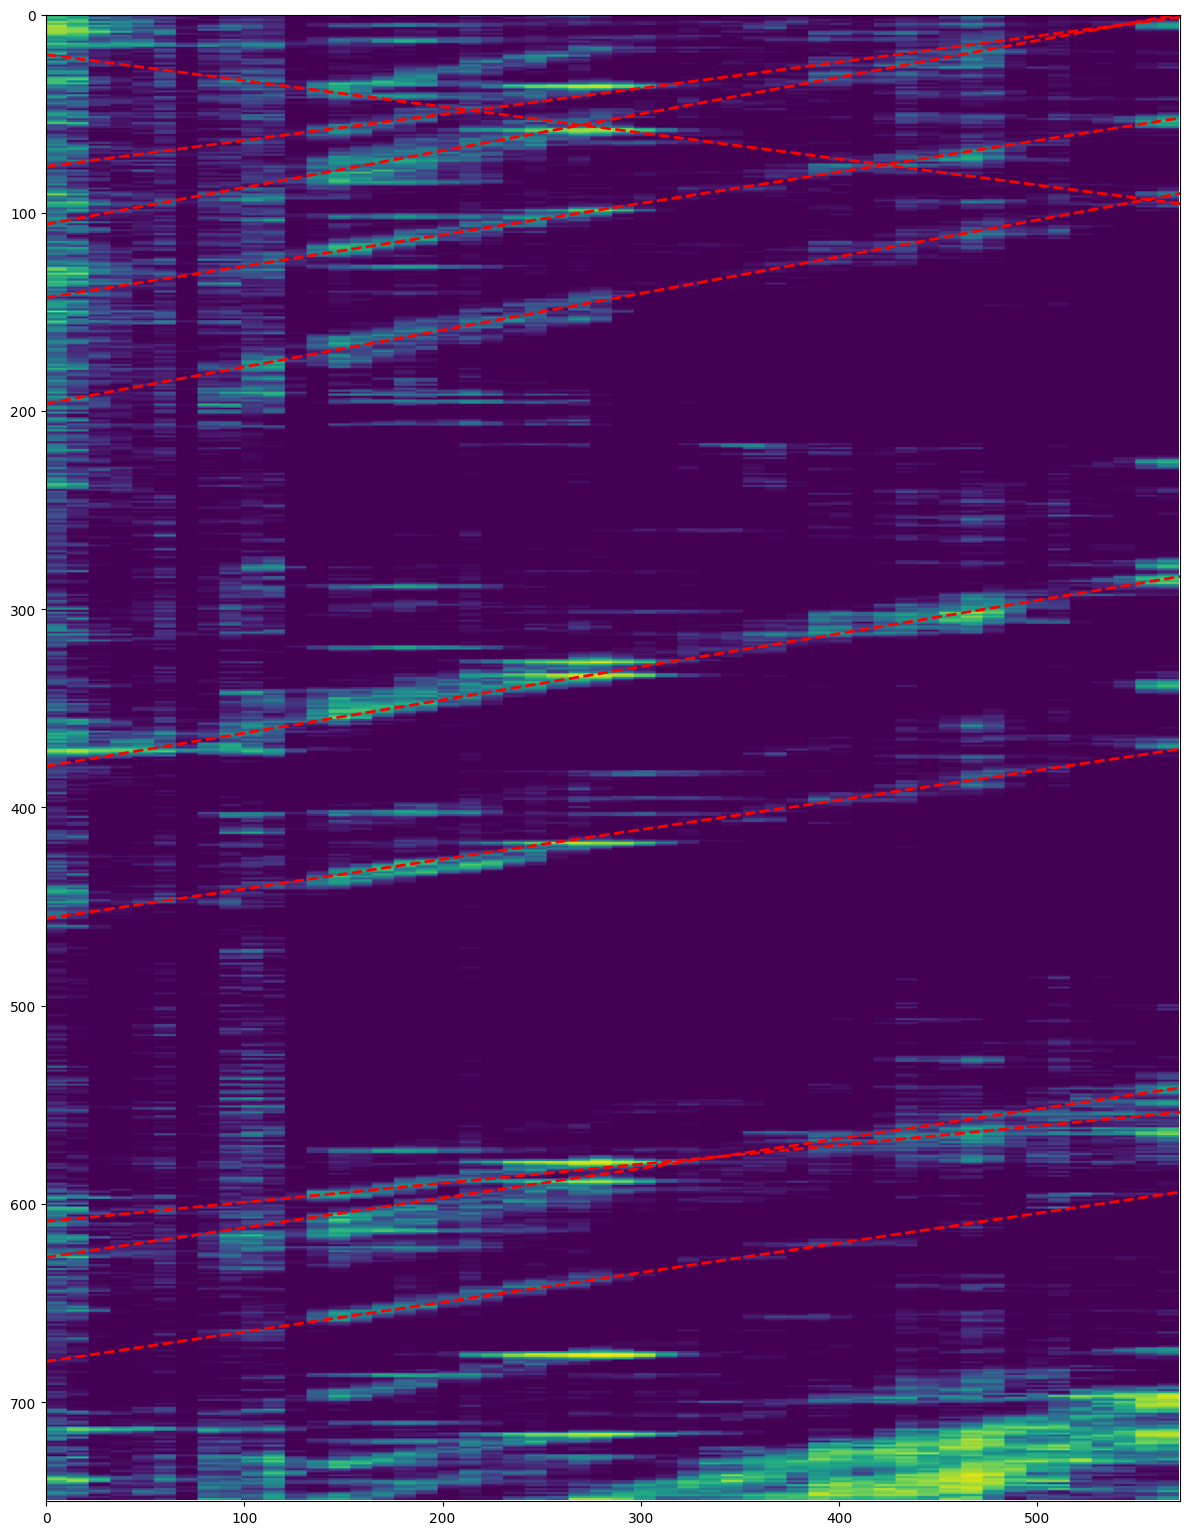

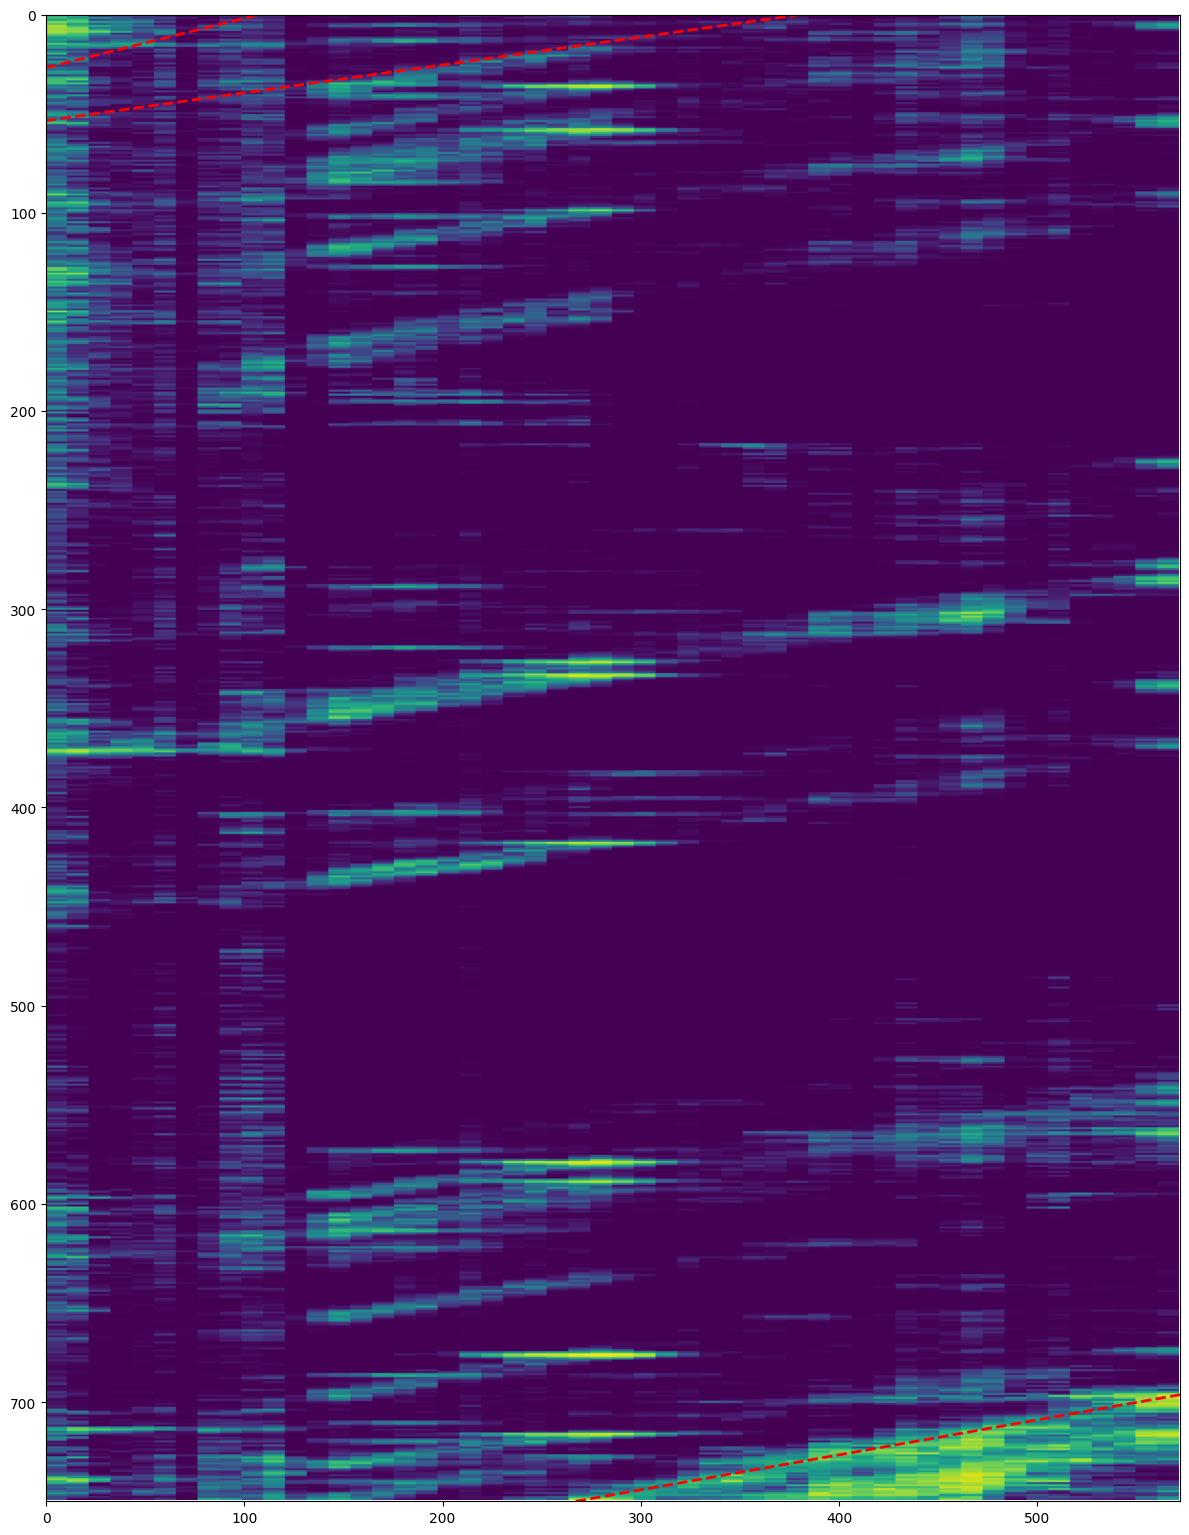

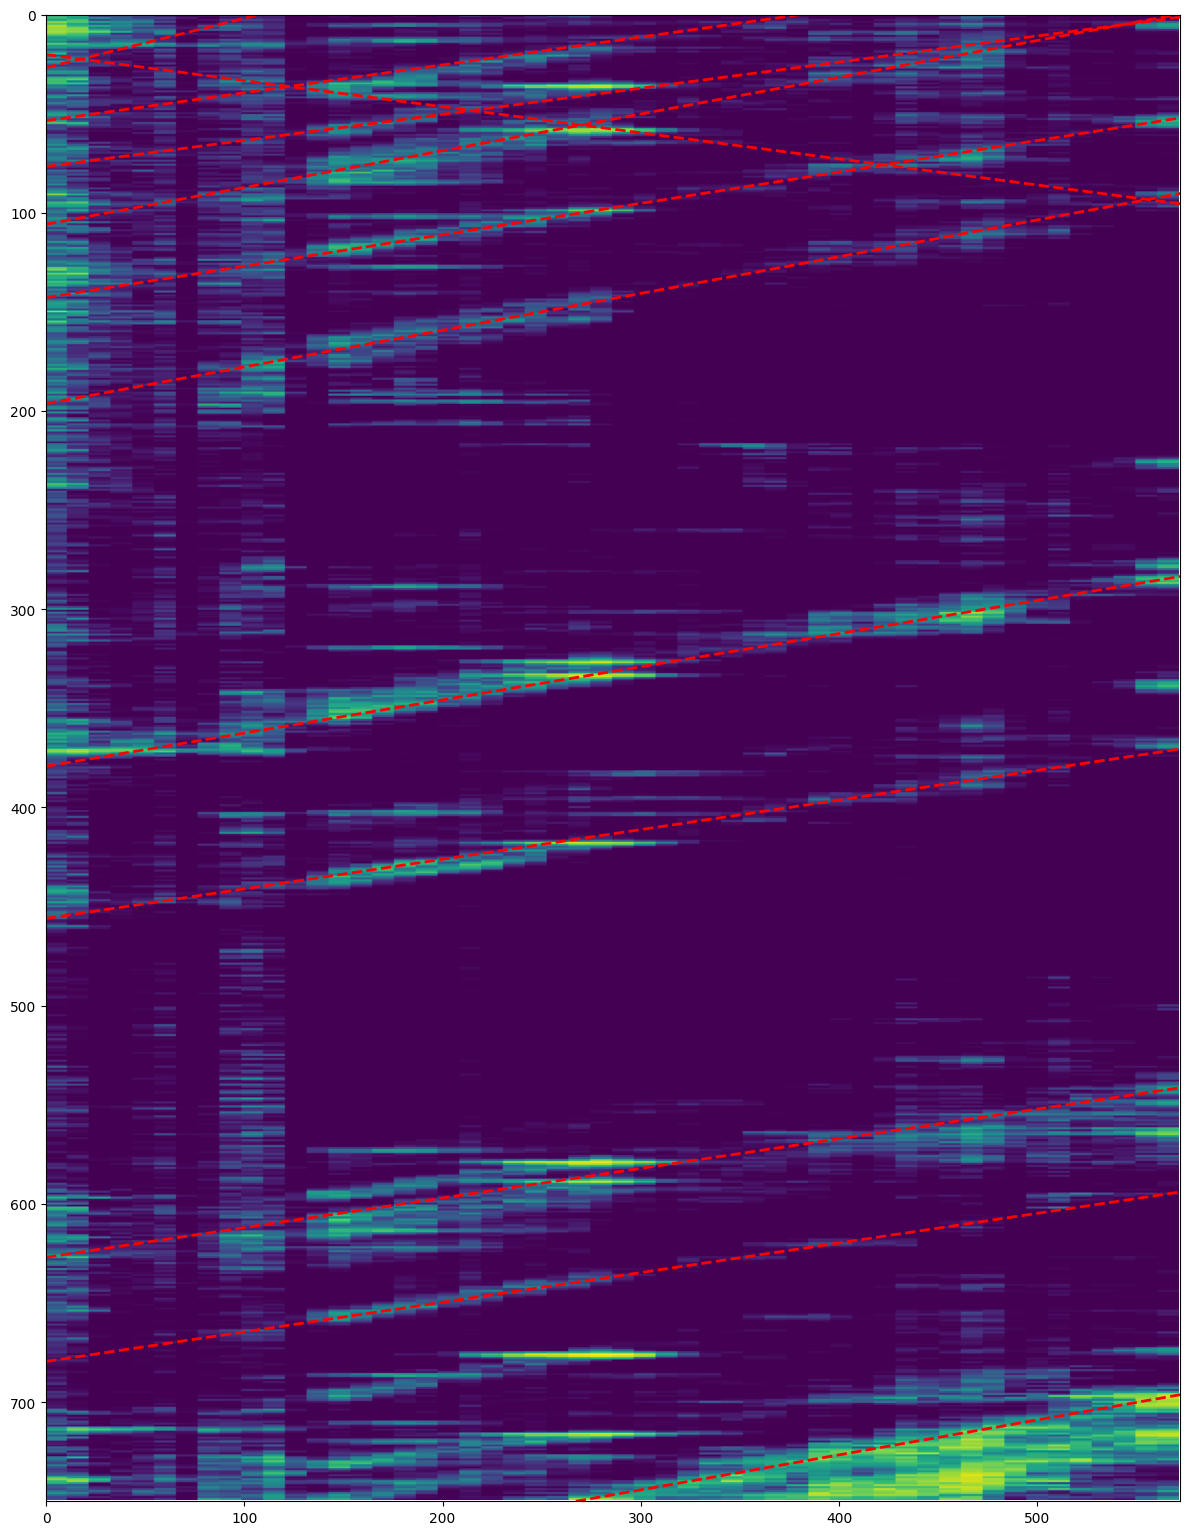

In [280]:
lines = detect_lines(scaled_img, 420)
display_lines_on_scaled_img(scaled_img, lines)

pad_lines = detect_lines_close_boundaries(scaled_img, 0.15, 500)
display_lines_on_scaled_img(scaled_img, pad_lines)

all_lines = lines+pad_lines
sorted_lines = sorted(all_lines, key=lambda x: -x[0])
true_lines = filter_lines(sorted_lines, 25)
display_lines_on_scaled_img(scaled_img, true_lines)

In [281]:
def display_detected_movements(df, lines, vert_scale, hor_scale):
    """
    Displays a visualization of detected movements with overlaid rescaled detected lines.

    Parameters:
    ----------
    df : pandas.DataFrame
        A 2D DataFrame containing the data to be visualized, where rows correspond to time steps and columns correspond to spatial positions.
        The values in the DataFrame represent the measurements or observations at each time step for each spatial point.

    lines : list of tuples
        A list of detected lines, where each line is represented as a tuple:
        (distance, angle, slope, speed).
    vert_scale : float
        Scaling factor to rescale vertical dimensions of the detected lines.
    hor_scale : float
        Scaling factor to rescale horizontal dimensions of the detected lines.

    Returns:
    -------
    None
        Displays the plot with a heatmap of movements and overlaid rescaled lines, along with labels indicating the speed of the lines.
    """
    fig = plt.figure(figsize=(12, 16))
    ax = plt.axes()

    low, high = np.percentile(df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)
    im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
    plt.ylabel('time [HH:MM:SS]')
    plt.xlabel('space [m]')

    for dist, angle, slope, speed  in lines:
        (x0, y0) = dist * np.array([np.cos(angle) * hor_scale, np.sin(angle) * vert_scale])
        slope_original = slope * vert_scale/hor_scale

        ax.axline((x0, y0), slope=slope_original, color='red', linewidth=2)
        offset = -700 
        x_text = x0 + 7
        y_text = slope_original * (x_text - x0) + y0 + offset

        if -1000 < y_text < 80000: # filters lines that are only in padded part of padded image
            rotation_angle = np.degrees(np.arctan(slope)) - 20*np.sign(slope)
            ax.text(
                x_text, y_text,
                f"{np.round(speed, 2)} km/h",
                fontsize=12,
                fontweight='bold',
                color='red',
                ha='center',
                va='center',
                rotation=rotation_angle,
                rotation_mode='anchor'
            )

    cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im, cax=cax)
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    ax.set_ylim((74999, 0))
    ax.set_xlim((0, 51))
    plt.show()    

vertical scale: 100.0 horizontal scale: 0.09090909090909091


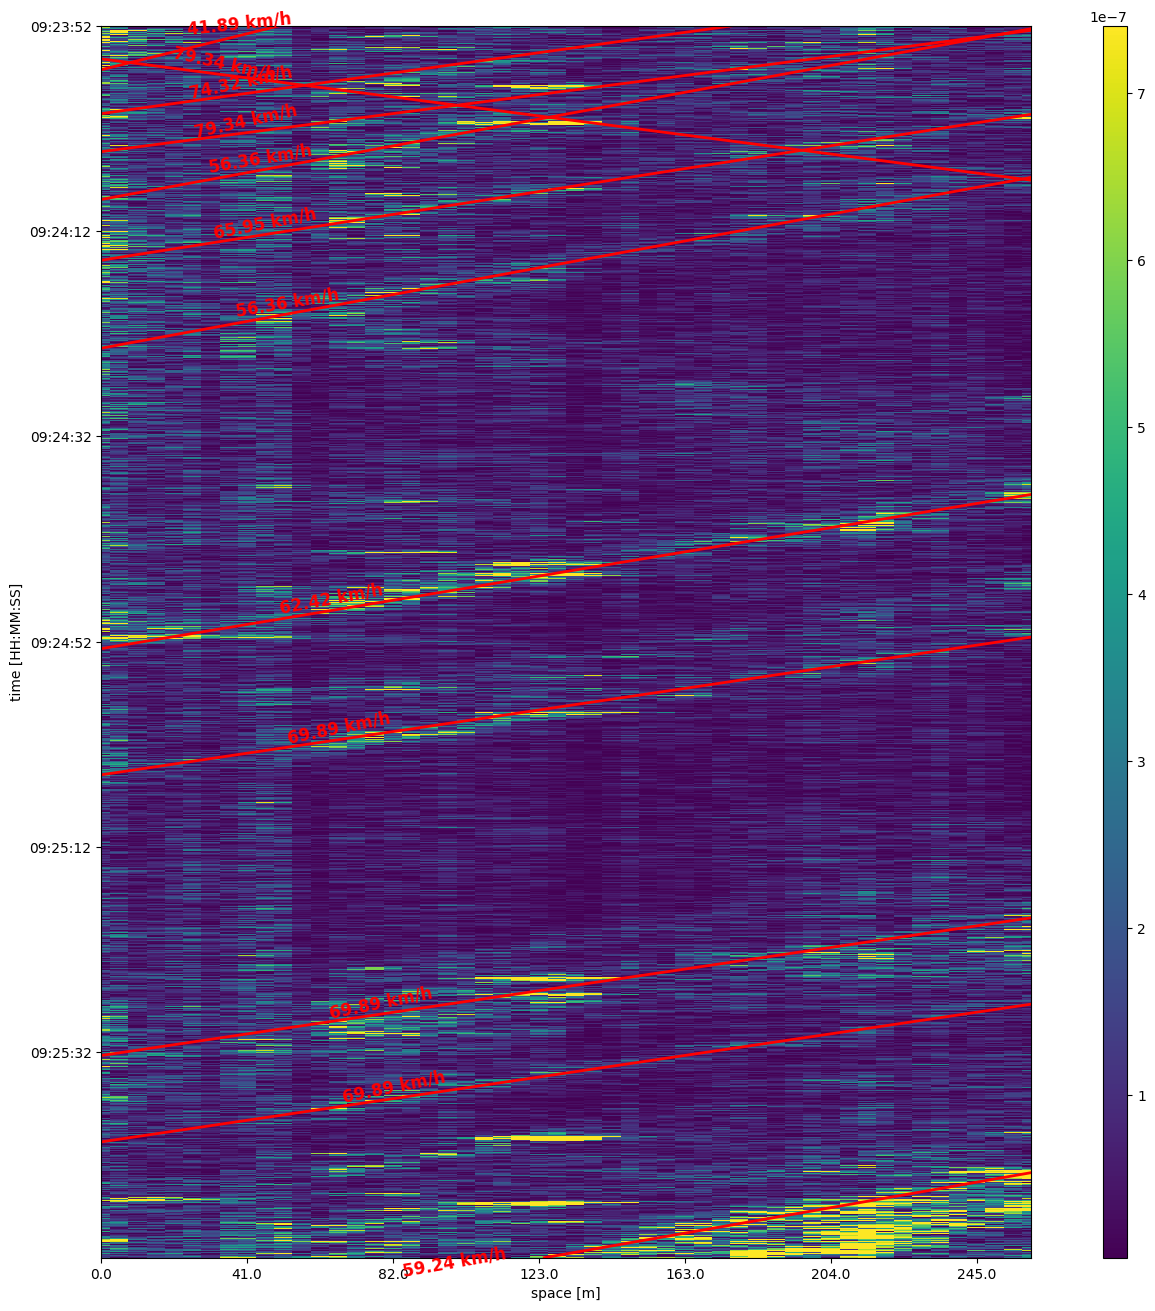

In [282]:
ver_scale = norm_mm_data.shape[0] / scaled_img.shape[0]
hor_scale = norm_mm_data.shape[1] / scaled_img.shape[1]
print("vertical scale:", ver_scale, "horizontal scale:", hor_scale)

display_detected_movements(df, true_lines, ver_scale, hor_scale)


C:\Users\user\AppData\Local\Temp\ipykernel_7544\2407331224.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
C:\Users\user\AppData\Local\Temp\ipykernel_7544\2407331224.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)


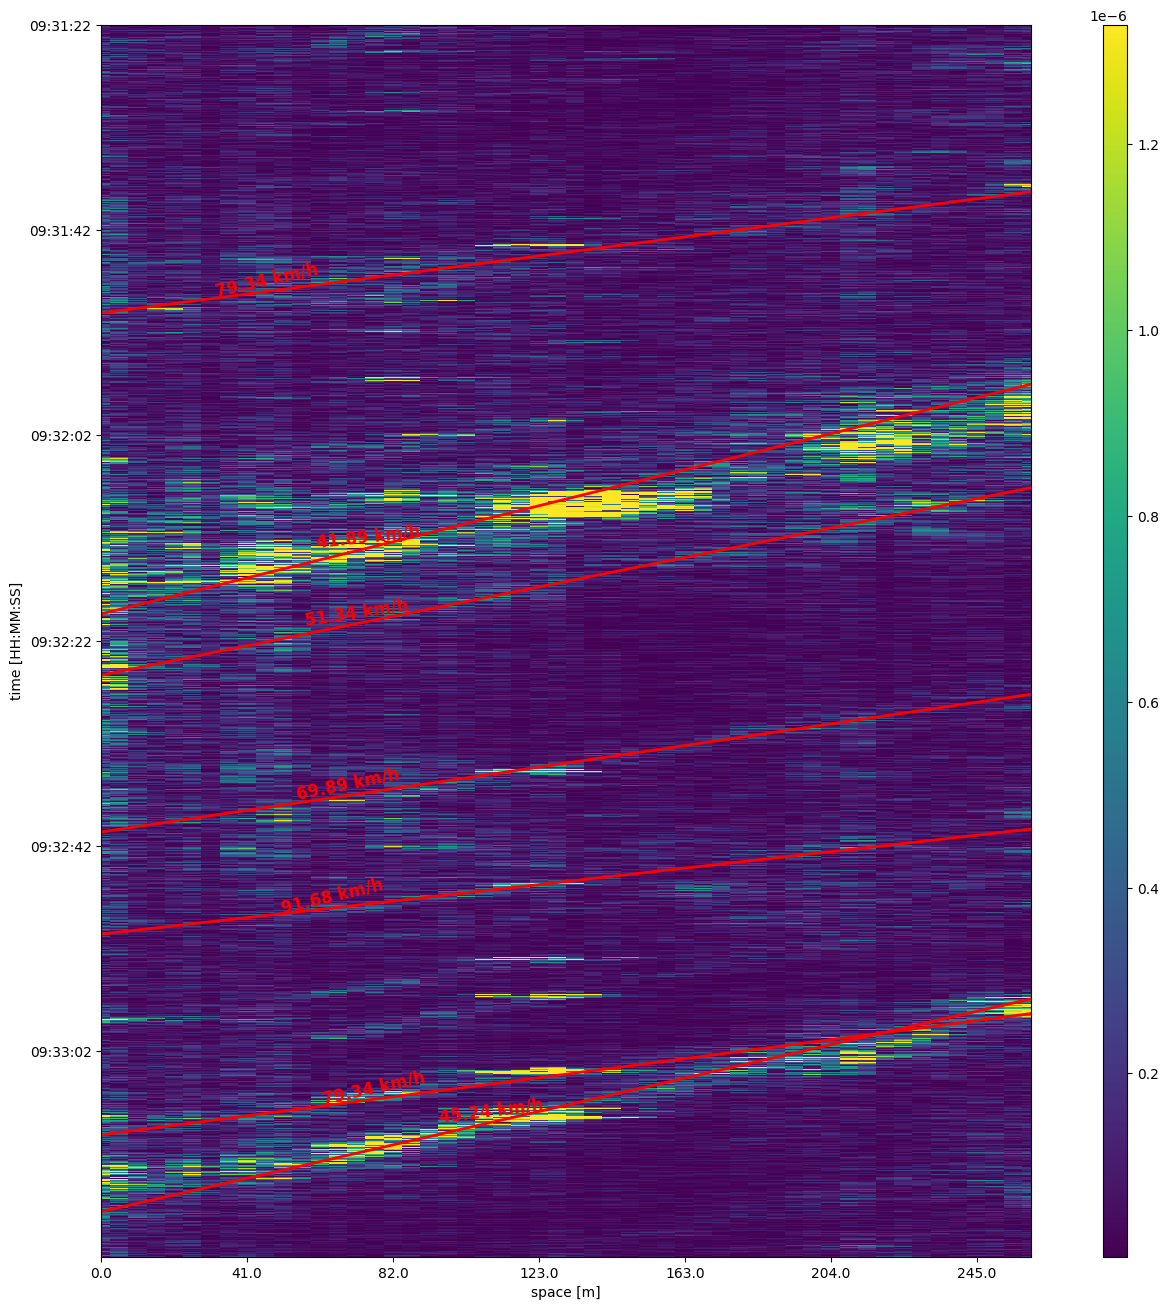

C:\Users\user\AppData\Local\Temp\ipykernel_7544\2407331224.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)
C:\Users\user\AppData\Local\Temp\ipykernel_7544\2407331224.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  speed = np.where(denominator != 0, 1 / np.abs(denominator) * 3.6, 0)


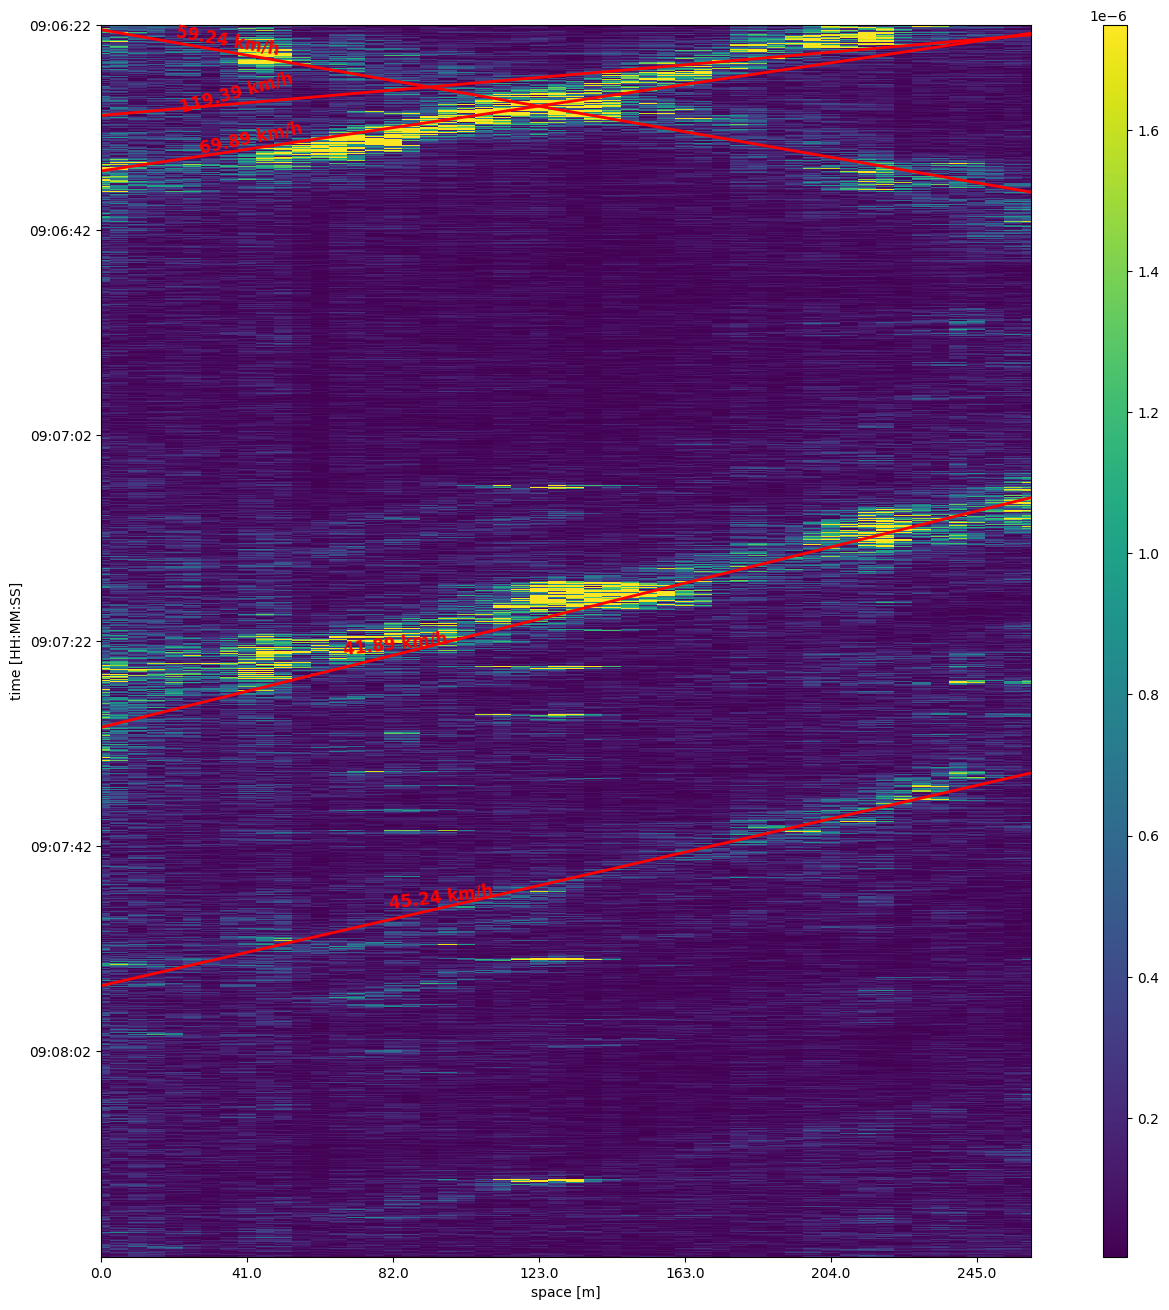

In [284]:
for times_frame in [('093122', '093312'), ('090622', '090812')]:
    data, first_file = get_time_interval(files, times_frame[0], times_frame[1])
    df = get_proper_df(data, first_file)

    low, high = np.percentile(df, [3, 99]) 
    norm_mm = Normalize(vmin=low, vmax=high, clip=True)
    norm_mm_data = norm_mm(abs(data))

    standardized_data = (abs(data) - np.mean(abs(data))) / np.std(abs(data))

    threshold = np.percentile(standardized_data, [86])
    binarized_img = norm_mm_data > threshold

    downsampled_img = downsample_vertical(binarized_img, factor=100)
    resized_img = expand_horizontal(downsampled_img, factor=11)
    scaled_img = scale_to_255(resized_img)

    lines = detect_lines(scaled_img, 420)
    pad_lines = detect_lines_close_boundaries(scaled_img, 0.15, 500)
    all_lines = lines+pad_lines
    sorted_lines = sorted(all_lines, key=lambda x: -x[0])
    true_lines = filter_lines(sorted_lines, 25)

    display_detected_movements(df, true_lines, ver_scale, hor_scale)